In [ ]:
# Mounting Google Drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/ProjectData/FaceRecognition/

/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition


In [ ]:
VM_path = '/content/dataset1'
drive_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2/'
drive_path_checkpoint = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/checkpoint/face_inceptionv3_3.hdf5'
VM_root = '/content'
VM_face_path = '/content/dataset2'

In [ ]:
!cp -r '{drive_path}' '{VM_root}'

In [ ]:
!mkdir /content/dataset1

In [ ]:
!rm -r /content/dataset1/*

rm: cannot remove '/content/dataset1/*': No such file or directory


In [ ]:
# Data Pre-Processing

In [ ]:
import cv2
import numpy
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow

In [ ]:
face_dec = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [ ]:
def getFace_haar(image):
  max = -1
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  faces = face_dec.detectMultiScale(image, 1.3,5)
  for (x,y,w,h) in faces:
    #print(w,h)
    if w < 20 or h <20:
      continue
    area = h*w
    if max < area:
      max = area
      x1 = x
      y1 = y
      x2 = x+w
      y2 = y+h

    return x1, x2, y1, y2
    

In [ ]:
#knownface = []
!rm -r /content/dataset1/*
count = 0
k = 1
facelabels = os.listdir(drive_path)
for f in facelabels:
  sorc = drive_path+'/'+f
  dest = VM_path+'/'+f
  os.mkdir(dest)
  img_list = os.listdir(sorc)
  print('Processing ',f, str(k), 'out of ', str(len(facelabels)), 'classes')
  k += 1
  for img in img_list:
    imgPath = sorc+'/'+img
    image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
    faces = face_dec.detectMultiScale(image)

    

    cord = getFace_haar(image)
    if cord == None:
      continue
    x1,x2, y1, y2 = cord
    face = image[y1:y2, x1:x2]
    face1 = cv2.resize(face, (256,256))
    
    
    savepath = dest+'/'+str(count)+'.png'
    
    count += 1
    '''
    cv2_imshow(face1)
    if count >= 5:
      break
    '''
    cv2.imwrite(savepath, face1)
  
  count = 0

rm: cannot remove '/content/dataset1/*': No such file or directory
Processing  Deepika_Padukone 1 out of  20 classes
Processing  Disha_Patani 2 out of  20 classes
Processing  Bhumi_Pednekar 3 out of  20 classes
Processing  Ayushmann_Khurrana 4 out of  20 classes
Processing  Hrithik_Roshan 5 out of  20 classes
Processing  Ileana_D_Cruz 6 out of  20 classes
Processing  Emraan_Hashmi 7 out of  20 classes
Processing  Farhan_Akhtar 8 out of  20 classes
Processing  Amitabh_Bachchan 9 out of  20 classes
Processing  Anushka_Sharma 10 out of  20 classes
Processing  Akshay_Kumar 11 out of  20 classes
Processing  Arshad_Warsi 12 out of  20 classes
Processing  Anil_Kapoor 13 out of  20 classes
Processing  Ajay_Devgn 14 out of  20 classes
Processing  Alia_Bhatt 15 out of  20 classes
Processing  Aishwarya_Rai 16 out of  20 classes
Processing  Aftab_Shivdasani 17 out of  20 classes
Processing  Abhay_Deol 18 out of  20 classes
Processing  Aamir_Khan 19 out of  20 classes
Processing  Abhishek_Bachchan 

In [ ]:
# Model Definition

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from keras.callbacks import ModelCheckpoint


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = VM_path

classes = glob(train_path+'/*')
NB_CLASS =len(classes)
NB_EPOCHS = 64

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 20,
                                   brightness_range = [0.5,1.5],
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='training')

testing_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='validation')



Found 1672 images belonging to 20 classes.
Found 408 images belonging to 20 classes.


In [ ]:
mod = InceptionV3(include_top=False,weights='imagenet', input_shape=(224,224,3))
for l in mod.layers:
  l.trainable = False

In [ ]:
mod.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
for l in mod.layers[-43:]:
  l.trainable = True

In [ ]:
mod.summary()
for l in mod.layers:
  print(l , l.trainable)

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
x = Flatten()(mod.output)
x = Dense(512, activation='relu')(x)
pred = Dense(NB_CLASS, activation='softmax')(x)
model = keras.Model(inputs = mod.input, outputs = pred)

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

checkpoint_filepath = drive_path_checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, save_freq='epoch')

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:
model_hist = model.fit(training_set, validation_data=testing_set, epochs=NB_EPOCHS, callbacks=[model_checkpoint])

Epoch 1/64
53/53 [==============================] - 41s 673ms/step - loss: 3.8199 - accuracy: 0.3456 - val_loss: 1.8002 - val_accuracy: 0.5441
Epoch 2/64
53/53 [==============================] - 35s 659ms/step - loss: 0.4899 - accuracy: 0.8396 - val_loss: 1.5194 - val_accuracy: 0.6740
Epoch 3/64
53/53 [==============================] - 35s 653ms/step - loss: 0.3915 - accuracy: 0.8847 - val_loss: 1.6369 - val_accuracy: 0.6397
Epoch 4/64
53/53 [==============================] - 34s 634ms/step - loss: 0.3771 - accuracy: 0.8701 - val_loss: 1.6302 - val_accuracy: 0.6324
Epoch 5/64
53/53 [==============================] - 34s 641ms/step - loss: 0.3018 - accuracy: 0.9034 - val_loss: 1.5660 - val_accuracy: 0.6691
Epoch 6/64
53/53 [==============================] - 34s 633ms/step - loss: 0.2254 - accuracy: 0.9197 - val_loss: 1.6090 - val_accuracy: 0.6667
Epoch 7/64
53/53 [==============================] - 34s 634ms/step - loss: 0.2312 - accuracy: 0.9245 - val_loss: 1.4188 - val_accuracy: 0.7059

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/transferInceptionV3_celeb_dataset.h5'
model.save(model_path)

In [ ]:
m = []
for i in range(NB_EPOCHS):
  m.append(i)

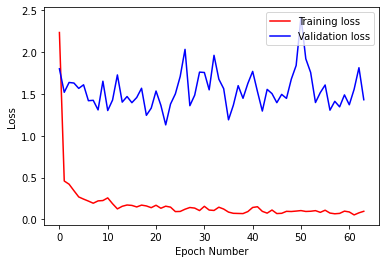

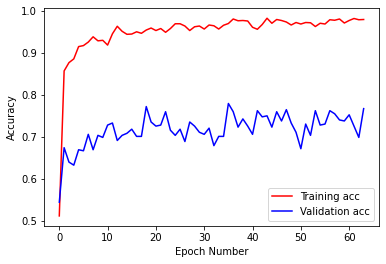

In [ ]:

loss_trace = model_hist.history['loss']
val_loss_trace = model_hist.history['val_loss']
plt.plot(m,loss_trace, c='r')
plt.plot(m,val_loss_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()


accuracy_trace = model_hist.history['accuracy']
val_accuracy_trace = model_hist.history['val_accuracy']
plt.plot(m,accuracy_trace, c='r')
plt.plot(m,val_accuracy_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'], loc='lower right')
plt.show()
